In [39]:
# 04_log_prediction

In [40]:
# Force to reload extrernal modules every new cell execution
%reload_ext autoreload
%autoreload 2

In [41]:
### IMPORT ###
from pathlib import Path
from datetime import datetime
import pandas as pd
import re
import numpy as np
# plot
import matplotlib.pyplot as plt
# ML
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
# DL
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
# XAI
import shap
from shap import Explanation
# Code warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [42]:
### LOCAL IMPORT ###
from config import config_reader
from utilities import extract_files, convert_seconds_to_hours

In [43]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")

dic_types = dict(yaml_config["EVENT_LOG_TYPES"]) 

encoding_dir = str(yaml_config["LOG_ENCODING_DIR"]) # <-- INPUT: the directory with files encoded for the ML models

# ML
ml_dir = str(yaml_config["ML_DIR"]) # <-- INPUT: the directoryin which to save ML results
label_column = "REMAINING_TIME_sec" # <-- INPUT: label for prediction
drop_column = ["CaseID", "TIMESTAMP"]  # <-- INPUT: columns to drop
cv_folds = int(yaml_config["CV_FOLDS"])

dic_task = {"DTR":0, "RFR":1, "XGR":0, "LSTM":0} # <-- INPUT: which model to execute

ht_do = 0 # <-- INPUT performs hypertuning: 1 yes, 0 no 
ht_str = None

# Event log types (stadard or enriched)
std_suffix = str(yaml_config["STD_SUFFIX"])
enr_suffix = str(yaml_config["ENR_SUFFIX"])

# PLOT
plot_dir = str(yaml_config["PLOT_DIR"])

# SHAP
shap_do = 1 # <-- INPUT performs SHAP: 1 yes, 0 no 
shap_dir = str(yaml_config["SHAP_DIR"])

# FUNCTIONS

In [44]:
def plot_custom_distribution_side_by_side_old(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str, model_name:str, ht_str:str) -> None:
    """
    This function takes a dataframe as input and displays a side-by-side bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    model_name (str): The name of the model used.
    ht_str (str): The model is hypertuned or not.
    """

    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Set font properties
    plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman'})

    # Extract unique values
    unique_x_values = dataframe[x_column].unique()
    unique_encodings = dataframe[encoding_column].unique()
    
    # Calculate width for each bar
    bar_width = 0.25  # Width of each bar
    index = np.arange(len(unique_x_values))  # The x locations for the groups

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot bars for each encoding
    for i, encoding in enumerate(unique_encodings):
        subset = dataframe[dataframe[encoding_column] == encoding]
        # Align the bars in each group
        plt.bar(index + i * bar_width, subset[y_column], bar_width, label=f'Encoding {encoding}')

    # Add titles and labels
    plt_title = f"Distribution of '{y_column}' by '{x_column}' \n Model: {model_name}"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(index + bar_width / 2, unique_x_values, rotation=45)
    plt.legend(title=encoding_column)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()

    file_path = f'plots/{model_name}_plot_{y_column}_{ht_str}_HT.png'
    plt.savefig(file_path)

    plt.show()

In [45]:
def plot_custom_distribution_side_by_side(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str, model_name: str, ht_str: str) -> None:
    """
    This function takes a dataframe as input and displays a side-by-side bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    model_name (str): The name of the model used.
    ht_str (str): The model is hypertuned or not.
    """

    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")

    # Set font properties
    plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman'})

    # Extract unique values
    unique_x_values = dataframe[x_column].unique()
    unique_encodings = dataframe[encoding_column].unique()

    # Calculate width for each bar
    bar_width = 0.25  # Width of each bar
    index = np.arange(len(unique_x_values))  # The x locations for the groups

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot bars for each encoding
    for i, encoding in enumerate(unique_encodings):
        subset = dataframe[dataframe[encoding_column] == encoding]
        # Align the bars in each group
        bars = plt.bar(index + i * bar_width, subset[y_column], bar_width, label=f'Encoding {encoding}')

        # Add data labels on top of each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black', fontsize=9)

    # Add titles and labels
    plt_title = f"Distribution of '{y_column}' by '{x_column}' \n Model: {model_name}"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(index + bar_width / 2 * len(unique_encodings), unique_x_values, rotation=45)
    plt.legend(title=encoding_column)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()

    file_path = f'plots/{model_name}_plot_{y_column}_{ht_str}_HT.png'
    plt.savefig(file_path)

    plt.show()

In [46]:
def perform_regression_lstm_base(X_train: pd.DataFrame,y_train: pd.Series, X_test: pd.DataFrame,y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, type: str,prefix: str, encoding: str,cv_folds: int = 5) -> dict:
    """
    Perform regression using LSTM and evaluate the model with RMSE and MAE.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing LSTM Regression")

    # Reshape for LSTM [samples, time steps, features]
    n_features = X_train.shape[1]
    print("n_features:", n_features) # debug
    X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
    print("X train reshape:", X_train_reshaped.shape) # debug
    print("X train reshape:", X_test_reshaped.shape) # debug

    # LSTM model 
    dropout_rate = 0.3
    units_num = 300
    reg_strength = 0.01

    model = Sequential()

    # First level
    model.add(Input(shape=(1, n_features)))
    model.add(Bidirectional(LSTM(units=units_num, activation='relu', kernel_regularizer=l2(reg_strength), return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Second level  
    model.add(Bidirectional(LSTM(units=units_num, activation='relu', kernel_regularizer=l2(reg_strength), return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Third level
    model.add(Bidirectional(LSTM(units=units_num, activation='relu', kernel_regularizer=l2(reg_strength)))) # return_sequences=True *not* needed in the last layer
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(1))

    # Model compilation
    # model.compile(optimizer='rmsprop', loss='mse')
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    # print(model.summary()) # debug
    
    # Utilizzo di early stopping per prevenire l'overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Addestramento del modello
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # Predizione sui dati di test
    y_pred = model.predict(X_test_reshaped)

    # Valutazione
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in seconds before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # Prepare reshaped features for cross-validation
    def lstm_cross_val_predictor(X, y, cv_folds, n_features):
        """ Cross-validation utility for LSTM."""
        scores_rmse = []
        scores_mae = []
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

        for train_index, test_index in kfold.split(X):
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            # Reshape folds for LSTM input
            X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], 1, n_features))
            X_test_fold = X_test_fold.reshape((X_test_fold.shape[0], 1, n_features))

            # Define model
            dropout_rate = 0.3
            units_num = 400
            reg_strength = 0.01

            model_fold = Sequential()

            # First level
            model_fold.add(Input(shape=(1, n_features)))
            model_fold.add(Bidirectional(LSTM(units=units_num, activation='relu', kernel_regularizer=l2(reg_strength), return_sequences=True)))
            model_fold.add(Dropout(dropout_rate))
            model_fold.add(BatchNormalization())

            # Second level  
            model_fold.add(Bidirectional(LSTM(units=units_num, activation='relu', kernel_regularizer=l2(reg_strength), return_sequences=True)))
            model_fold.add(Dropout(dropout_rate))
            model_fold.add(BatchNormalization())

            # Third level
            model_fold.add(Bidirectional(LSTM(units=units_num, activation='relu', kernel_regularizer=l2(reg_strength)))) # return_sequences=True *not* needed in the last layer
            model_fold.add(Dropout(dropout_rate))
            model_fold.add(BatchNormalization())

            # Output layer
            model_fold.add(Dense(1))

            # Model compilation
            # model.compile(optimizer='rmsprop', loss='mse')
            model_fold.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

            # Train model
            early_stopping_fold = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model_fold.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping_fold])

            # Evaluate model
            y_pred_fold = model_fold.predict(X_test_fold)
            rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
            mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

            scores_rmse.append(rmse_fold)
            scores_mae.append(mae_fold)

        return np.array(scores_rmse), np.array(scores_mae)

    # Prepare data for cross-validation
    X_cv = df_log_ml_features.values
    y_cv = target.values

    # Reshape features for LSTM input
    X_cv = X_cv.reshape((X_cv.shape[0], 1, n_features))

    # Cross-validation scores
    cv_rmse_scores, cv_mae_scores = lstm_cross_val_predictor(X_cv, y_cv, cv_folds, n_features)

    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean:.2f}, MAE std: {cv_mae_std:.2f}")
    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")
    print()
    
    results_dict = {
        "Model": "LSTM",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, model

In [47]:
def perform_regression_dtr_base(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name:str, type:str, prefix:str, encoding:str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Decision Tree and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing DTR")
    # Training
    dt_regressor = DecisionTreeRegressor(random_state=42)
    dt_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = dt_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(dt_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(dt_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean:.2f}, MAE std: {cv_mae_std:.2f}")
    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")
    print()

    results_dict = {
        "Model": "DTR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, dt_regressor

In [48]:
def perform_regression_rfr_base(X_train: pd.DataFrame, y_train: pd.Series, X_test:pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name:str, type:str, prefix:str, encoding:str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Random Forest and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing RFR")
    # Training
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")
    print()
    
    results_dict = {
    "Model": "RFR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, rf_regressor

In [49]:
def perform_regression_xgr_base(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, type:str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using XGBoost and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing XGBoost Regression")

    # Training the model
    xgb_regressor = XGBRegressor(n_estimators=150, random_state=42, verbosity=0)
    xgb_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = xgb_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")
    print()
    
    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, xgb_regressor

In [50]:
def perform_regression_rfr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, type:str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Random Forest with hyperparameter optimization using Hyperopt.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics and best hyperparameters.
    """
    print(">> Performing RFR")
    
    def objective(params):
        
        rf_regressor = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=params['max_depth'],
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            max_features=params.get('max_features', 'auto'),
            bootstrap=params.get('bootstrap', True),
            oob_score=params.get('oob_score', False),
            random_state=42
        )
        
        # Scorer define for RMSE (negative since cross_val_score minimizes the score)
        neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

        # Cross-validation to get the negative RMSE
        cv_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)
        
        # Convert the negative scores to positive for RMSE
        cv_rmse_scores = -cv_scores
        cv_rmse_mean = cv_rmse_scores.mean()
        
        return {'loss': cv_rmse_mean, 'status': STATUS_OK}

    # Define the hyperparameter space
    param_space = {
            'n_estimators': [int(x) for x in range(10, 501, 50)],  
            'max_depth': [int(x) for x in range(5, 51, 5)] + [None], 
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 10],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False],
            'oob_score': [True, False]
        }

    # Run the optimization
    trials = Trials()
    best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)

    print("Best hyperparameters found: ", best)

    # Train the model with the best hyperparameters
    rf_regressor = RandomForestRegressor(
        n_estimators=int(best['n_estimators']),
        max_depth=int(best['max_depth']),
        min_samples_split=int(best['min_samples_split']),
        min_samples_leaf=int(best['min_samples_leaf']),
        random_state=42
    )
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")
    print()
    
    results_dict = {
        "Model": "RFR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m,
        "Best_Hyperparameters": best  # Added best hyperparameters
    }

    return results_dict, rf_regressor

In [51]:
# HYPEROPT
def perform_regression_xgr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, type:str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using XGBoost with hyperparameter optimization and evaluate the model with RMSE.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing XGBoost Regression with Hyperopt")

    # Objective function for Hyperopt
    def objective(params):
        model = XGBRegressor(
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            n_estimators=params['n_estimators'],
            random_state=42,
            verbosity=0
        )
        # Using cross-validation to evaluate the model
        neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
        cv_scores = cross_val_score(model, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)
        return -cv_scores.mean()  # Minimize negative RMSE

    # Define the hyperparameter space
    param_space = {
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'n_estimators': hp.choice('n_estimators', [100, 150, 200, 250, 300]),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
    }
    
    # Optimize hyperparameters
    trials = Trials()
    best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)

    print("Best hyperparameters:", best)

    # Train the final model with best hyperparameters
    xgb_regressor = XGBRegressor(
        max_depth=int(best['max_depth']),
        learning_rate=best['learning_rate'],
        subsample=best['subsample'],
        colsample_bytree=best['colsample_bytree'],
        n_estimators=best['n_estimators'],
        random_state=42,
        verbosity=0
    )
    xgb_regressor.fit(X_train, y_train)

    # Test the model
    y_pred = xgb_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")
    print()

    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m,
        "Best_Hyperparameters": {
            "max_depth": int(best['max_depth']),
            "learning_rate": best['learning_rate'],
            "subsample": best['subsample'],
            "colsample_bytree": best['colsample_bytree'],
            "n_estimators": best['n_estimators']
        }
    }

    return results_dict, xgb_regressor

In [52]:
def explain_tree_model_shap(model: BaseEstimator, X_train: pd.DataFrame, X_test: pd.DataFrame, directory: str, type:str, prefix:str, encoding:str, ht_str:str):
    """
    Explains a tree-based regression model using SHAP and saves the plot.

    Parameters:
        model (BaseEstimator): The trained regression model.
        X_train (pd.DataFrame): The training dataset (features).
        X_test (pd.DataFrame): The testing dataset (features).
        directory (str): The directory where the plot should be saved.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        ht_str (str): hypertuning (yes/no)
    Returns:
        shap.Explainer, Explanation: A tuple containing the SHAP explainer and SHAP values.
    """

    print(">> Performing SHAP")
    
    # Get the model name
    model_name = str(model.__class__.__name__)

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(model, data=X_train)
    shap_values = explainer.shap_values(X_test, check_additivity=False)


    # Define a common file name pattern
    path = Path(directory)
    file_name_pattern = f"{model_name}_shap_{type}_prefix_{prefix}h_{encoding}_HT_{ht_str}"


    # 1. Summary plot
    plt.figure(figsize=(10, 7))
    shap.summary_plot(shap_values, X_test, show=False)
    plt_title = f"SHAP Summary Plot \n Model: {model_name} - Type: {type} - Prefix: {prefix} - Encoding: {encoding}"
    plt.title(plt_title)
    summary_plot_path = path / f"{file_name_pattern}_summary.png"
    plt.savefig(summary_plot_path)
    plt.close()
    print(f"SHAP summary plot saved as: {summary_plot_path}")

    # 2. Dependence plot for the first feature (change 'feature_name' as needed)
    feature_name = X_test.columns[0]  # Change this to any specific feature you're interested in
    plt.figure(figsize=(10, 7))
    shap.dependence_plot(feature_name, shap_values, X_test, show=False)
    plt_title = f"SHAP Dependence Plot ({feature_name}) \n Model: {model_name} - Type: {type} - Prefix: {prefix} - Encoding: {encoding}"
    plt.title(plt_title)
    dependence_plot_path = path / f"{file_name_pattern}_dependence_{feature_name}.png"
    plt.savefig(dependence_plot_path)
    plt.close()
    print(f"SHAP dependence plot saved as: {dependence_plot_path}")

    # 3. Force plot for the first instance
    force_plot_path = path / f"{file_name_pattern}_force.png"
    shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)
    plt_title = f"SHAP Force Plot \n Model: {model_name} - Type: {type} - Prefix: {prefix} - Encoding: {encoding}"
    plt.title(plt_title)
    plt.savefig(force_plot_path)
    plt.close()
    print(f"SHAP force plot saved as: {force_plot_path}")

    # 4. Waterfall plot for the first instance
    plt.figure(figsize=(10, 7))
    shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test.iloc[0]))
    plt_title = f"SHAP Waterfall Plot \n Model: {model_name} - Type: {type} - Prefix: {prefix} - Encoding: {encoding}"
    plt.title(plt_title)
    waterfall_plot_path = path / f"{file_name_pattern}_waterfall.png"
    plt.savefig(waterfall_plot_path)
    plt.close()
    print(f"SHAP waterfall plot saved as: {waterfall_plot_path}")


    return explainer, shap_values

# MAIN

In [53]:
### MAIN ###
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

# print(yaml_config) # debug


*** PROGRAM START ***

Start process: 2024-08-11 13:57:18



In [54]:
print(">> Creating output directories")
dir_list = []
dir_list.append(Path(ml_dir))
dir_list.append(Path(plot_dir))
dir_list.append(Path(shap_dir))

for dir_name in dir_list:
    dir_name.mkdir(parents=True, exist_ok=True)
    print(f"Directory '{dir_name}' created successfully.")

>> Creating output directories
Directory 'data_ml' created successfully.
Directory 'plots' created successfully.
Directory 'shap' created successfully.


In [55]:
print(">> Listing event log prefixes files")
list_files = extract_files(encoding_dir, "csv")
list_files_len = len(list_files)
print("Files found (num):", list_files_len)
print("Files found (list):", list_files)
print()

print("> Splitting standad and enriched")

list_files_std = [file for file in list_files if f'_{std_suffix}_' in file]
list_files_std_len = len(list_files_std)

list_files_enr = [file for file in list_files if f'_{enr_suffix}_' in file]
list_files_enr_len = len(list_files_enr)

print("Files standard found (num):", list_files_std_len)
print("Files standard found (list):", list_files_std)
print("Files enriched found (num):", list_files_enr_len)
print("Files enriched found (list):", list_files_enr)

>> Listing event log prefixes files
Files found (num): 18
Files found (list): ['EVENT-LOG_ED_duration_enr_prefix_1h_B.csv', 'EVENT-LOG_ED_duration_enr_prefix_1h_F.csv', 'EVENT-LOG_ED_duration_enr_prefix_1h_I.csv', 'EVENT-LOG_ED_duration_enr_prefix_2h_B.csv', 'EVENT-LOG_ED_duration_enr_prefix_2h_F.csv', 'EVENT-LOG_ED_duration_enr_prefix_2h_I.csv', 'EVENT-LOG_ED_duration_enr_prefix_3h_B.csv', 'EVENT-LOG_ED_duration_enr_prefix_3h_F.csv', 'EVENT-LOG_ED_duration_enr_prefix_3h_I.csv', 'EVENT-LOG_ED_duration_std_prefix_1h_B.csv', 'EVENT-LOG_ED_duration_std_prefix_1h_F.csv', 'EVENT-LOG_ED_duration_std_prefix_1h_I.csv', 'EVENT-LOG_ED_duration_std_prefix_2h_B.csv', 'EVENT-LOG_ED_duration_std_prefix_2h_F.csv', 'EVENT-LOG_ED_duration_std_prefix_2h_I.csv', 'EVENT-LOG_ED_duration_std_prefix_3h_B.csv', 'EVENT-LOG_ED_duration_std_prefix_3h_F.csv', 'EVENT-LOG_ED_duration_std_prefix_3h_I.csv']

> Splitting standad and enriched
Files standard found (num): 9
Files standard found (list): ['EVENT-LOG_ED_dur

In [56]:
print(">> Hypertuning settings")
ht_str = "no" if ht_do == 0 else "yes"
print(ht_str)

>> Hypertuning settings
no


>> Reading event log prefixes files and applying ML / DL
[1 / 18]
File: data_encoding/EVENT-LOG_ED_duration_enr_prefix_1h_B.csv
Type (std / enr): enr
Prefix length: 1
Encoding: B
Event log shape: (11289, 195)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
Input features: 192
>> Performing RFR
RMSE of the model in second before CV: 602.6350692956121
MAE of the model in seconds before CV: 340.6356096366358
> CV validation
Folds: 5
RMSE of every fold in seconds: [1386.86730469  941.26193179 1263.55774052 1099.30549136 1500.23460366] 
 RMSE mean: 1238.25, RMSE std: 199.43
MAE of every fold in seconds: [580.63245336 565.25237342 604.56750001 561.54086369 682.87576349] 
 MAE mean: 598.9737907930448:.2f, RMSE std: 44.60
Cross-validated RMSE mean: 20.64 minutes, 0.34 hours
Cross-validated RMSE std: 3.32 minutes, 0.06 hours
Cross-validated MAE mean: 9.98 minutes, 0.17 hours
Cross-validated MAE std: 0.74 minutes, 0.01 hours

>> Performing SHAP


100%|===================| 2252/2258 [00:38<00:00]        

SHAP summary plot saved as: shap/RandomForestRegressor_shap_enr_prefix_1h_B_summary.png
SHAP dependence plot saved as: shap/RandomForestRegressor_shap_enr_prefix_1h_B_dependence_ACTIVE_CaseID.png


<Figure size 1000x700 with 0 Axes>

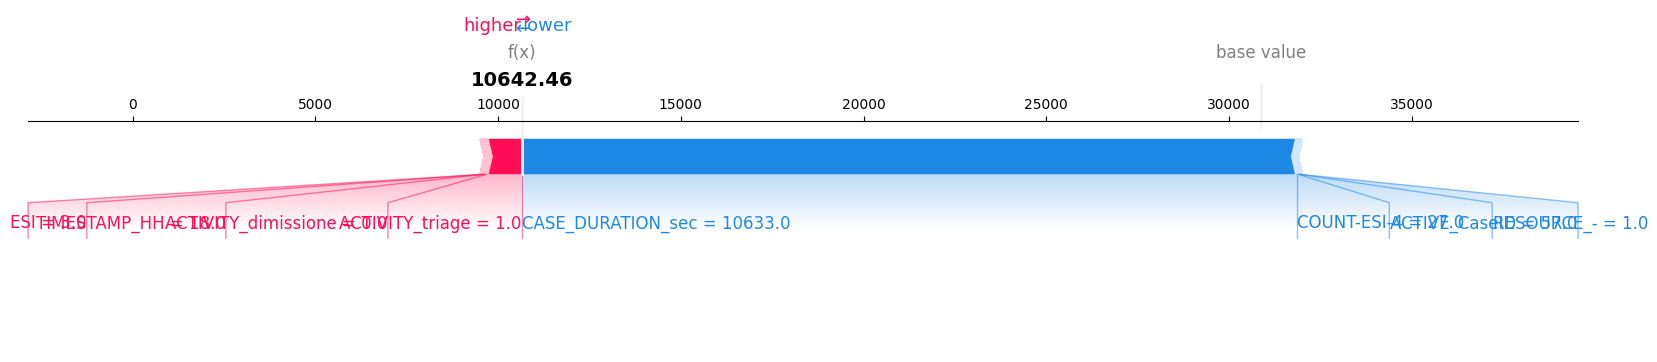

SHAP force plot saved as: shap/RandomForestRegressor_shap_enr_prefix_1h_B_force.png


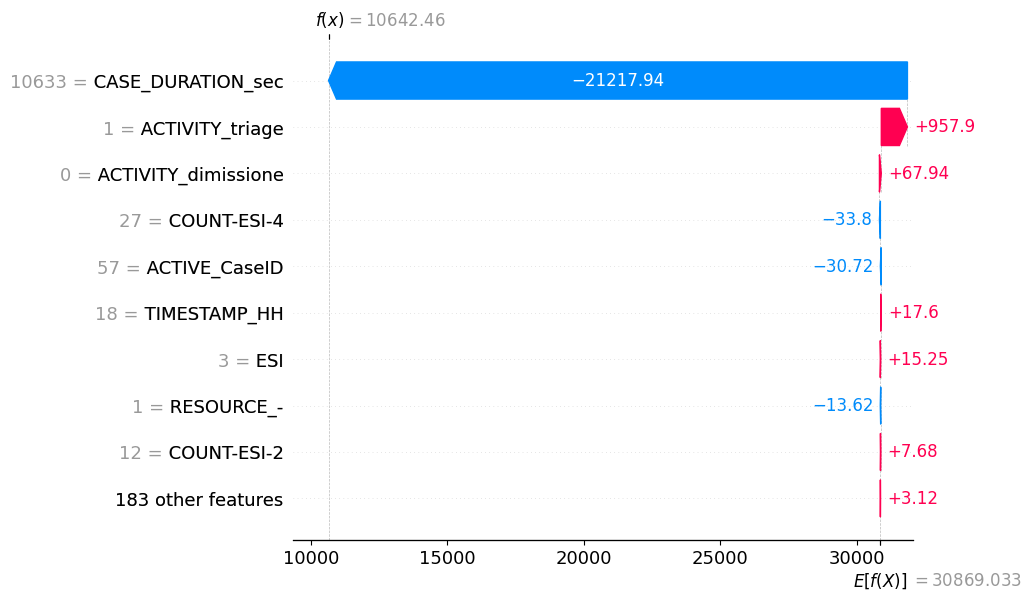

SHAP waterfall plot saved as: shap/RandomForestRegressor_shap_enr_prefix_1h_B_waterfall.png


TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

<Figure size 1000x700 with 0 Axes>

In [57]:
list_results_ml = []
print(">> Reading event log prefixes files and applying ML / DL")
i = 1
for file_name in list_files:
    print(f"[{i} / {list_files_len}]")
    path_data = Path(encoding_dir) / file_name
    print("File:", path_data)

    # Get from the file_name type, prefix length and encoding type
    pattern = r'duration_(enr|std)_prefix_(\d+)h_([A-Z])' 
    match = re.search(pattern, file_name)
    type = match.group(1)
    prefix = match.group(2)
    encoding = match.group(3)
    print("Type (std / enr):", type )
    print("Prefix length:", prefix)
    print("Encoding:", encoding)

    df_log = pd.read_csv(path_data, sep=";", dtype=dic_types)
    print("Event log shape:", df_log.shape)
    print("Event log cases:", df_log["CaseID"].nunique())
    # print(df_log.columns) # debug

    print("> Removing columns")
    print(drop_column)
    df_log_ml = df_log.drop(drop_column, axis=1)

    print("> Preparing data for regression")
    df_log_ml_features = df_log_ml.drop(columns=['REMAINING_TIME_sec'], axis=1) # Final features as input to the model
    print("Input features:", len(df_log_ml_features.columns))
    
    # Select the "label"
    target = df_log_ml[label_column]

    # Training and Test split
    X_train, X_test, y_train, y_test = train_test_split(df_log_ml_features, target, test_size=0.2, random_state=42)

    results_dict = None 
    dtr_regressor = None
    rfr_regressor = None
    xgb_regressor = None

    if dic_task["DTR"] == 1:
        results_dict, dtr_regressor = perform_regression_dtr_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
        list_results_ml.append(results_dict)
    
    if dic_task["RFR"] == 1:
        if ht_do==1:
            results_dict, rfr_regressor = perform_regression_rfr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
        else:
            results_dict, rfr_regressor = perform_regression_rfr_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
        if shap_do ==1:
            explainer, shap_values = explain_tree_model_shap(rfr_regressor, X_train, X_test, shap_dir, type, prefix, encoding, ht_str)
        list_results_ml.append(results_dict)

    # Performs the function with hypertuning or the basic function
    if dic_task["XGR"] == 1:
        if ht_do==1:
            results_dict, xgb_regressor = perform_regression_xgr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
        else:
            results_dict, xgb_regressor = perform_regression_xgr_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
        list_results_ml.append(results_dict)

    if dic_task["LSTM"] == 1:
        results_dict, lstm_regressor = perform_regression_lstm_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
        list_results_ml.append(results_dict)

    i+=1
    
    print("-"*8)

In [ ]:
print(">> Creating ML results")
df_ml = pd.DataFrame.from_records(list_results_ml)
df_ml = df_ml.sort_values(by = ["File"])
df_ml

In [ ]:
print(">> Splitting the results by model and event log type")
list_models = sorted(df_ml["Model"].unique().tolist())
list_types = sorted(df_ml["Type"].unique().tolist())
print("Available models:", list_models)
print("Available types:", list_types)
for model_name in list_models:
    df_ml_model = df_ml[df_ml["Model"] == model_name]
    for type_name in list_types:
        df_ml_model_type = df_ml_model[df_ml_model["Type"] == type_name]
        plot_custom_distribution_side_by_side(df_ml_model_type, "Prefix (h)", "RMSE_CV_Mean_m", "Encoding", f"{model_name} ({type_name})", ht_str)
        plot_custom_distribution_side_by_side(df_ml_model_type, "Prefix (h)", "MAE_CV_Mean_m", "Encoding", f"{model_name} ({type_name})", ht_str)

In [ ]:
print(">> Saving ML results for standard event log")

path_out = Path(ml_dir) / f"ML_results_{ht_str}_HT.csv"
print("File:", path_out)
df_ml.to_csv(path_out, sep=";", index=False)

path_out = Path(ml_dir) / f"ML_results_{ht_str}_HT.xlsx"
print("File:", path_out)
df_ml.to_excel(path_out, index=False, sheet_name=f"ML_results_{ht_str}_HT")

In [ ]:
# program end
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()